# Assignment 1  
## Non-linearity and low wavenumber update 

The goal for this notebook is to understand the important of low-wavenumber in the inversion. It will only requires minipulation of the data/initial model. Thus, the main inversion code is imported as class and we will run it as is without modification.



### Tasks: 

     - Aplpy FWI using the full data spectrum on: 
     
             1-  A smooth initial model (vsmooth.npy)
               
             2-  A v(z) model (vz.npy)
 
     - Apply a multi-scale approach to improve the inversion of v(z), 
         why did you decide on chosing these frequency bands ? 
 
     - Compare the inversion with and without the multi-scale approach, explain the reason for this behavior. 


In [1]:
import numpy as np
import fwi
import torch
import time
import matplotlib.pylab  as plt
import deepwave
from scipy import signal
from  scipy.ndimage import gaussian_filter
import math
import numbers


####  Functions

In [2]:
def plot_model(m,par):
    """
    plot the velocity model 
    
    Arguments
    ----------
    m: 2D numpy array 
        The velocity model  
    par: dictionary 
        A dictionary containing the parameter for the model (nx,dx,nz,dz)        
    """
    

    vmin, vmax = np.percentile(m.T,[2,98])
    plt.figure(figsize=(10,3))
    plt.imshow(m,cmap='jet',vmin=vmin,vmax=vmax,extent=[par['ox'],par['dx']*par['nx'],par['nz']*par['dz'],par['oz']])
    plt.axis('tight')
    plt.xlabel('Distance')
    plt.ylabel('Depth')
    plt.colorbar()
    plt.show(block=False)
    
    
def plot_shot(data,idx,par):
    """
    plot a shot gather 
    
    Arguments
    ----------
    data: 3D numpy array 
         array containing the shot gathers
    idx : int 
        the index of the shot gather to be plotted
    par: dictionary 
        A dictionary containing the parameter for the shot (nt,dt,nt,dt)        
    """
    vmin, vmax = np.percentile(data[:,idx].cpu().numpy(), [2,98])
    plt.figure()
    plt.imshow(data[:,idx].cpu().numpy(), aspect='auto',
           vmin=vmin, vmax=vmax,cmap='gray',extent=[par['orec']+idx*par['ds'],par['orec']+idx*par['ds']+par['dr']*par['nr'],
                                                    par['nt']*par['dt'],par['ot']])
    plt.ylabel('Time (s)')
    plt.xlabel('Distance (km)')
    
    
def mask(m,value):
    """
    Return a mask for the model (m) using the (value)
    """
    msk = m > value
    msk = msk.astype(int)
    return msk



#### Define the parameters and I/O files 

In [3]:
device = torch.device('cuda:0')

# I/O file 
# input files 
path = './input_files/'
# Fvel = path + 'vsmooth.npy'   # initial vel
Fvel = path + 'vz.npy'   # linear vel
Fwav = path + 'wavelet15.npy' # wavelet
Fdata = path + 'observed_data.npy' # observed data
# output file 

par = {'nx':601,   'dx':0.015, 'ox':0,
       'nz':211,   'dz':0.015, 'oz':0,
       'ns':30,    'ds':0.3,   'os':0,  'sz':0,
       'nr':601,   'dr':0.015,  'orec':0, 'rz':0,
       'nt':3000,  'dt':0.0015,  'ot':0,
       'freq':15,
       'num_batches':10,
       'FWI_itr': 100
      }



# Do Not touch the below lines 
nx = par['nx']
nz = par['nz']
dx = par['dx']
dt = par['dt']
fs = 1/par['dt']
nt = par['nt']
num_dim = 2
num_shots = par['ns']
num_batches = par['num_batches']
num_sources_per_shot=1
num_receiver_per_shot= par['nr']
source_spacing = par['ds']
receiver_spacing = par['dr']
receivers_depth = par['sz']
source_depth = par['rz']
orec = par['orec']
os = par['os']
FWI_itr = par['FWI_itr']
freq=par['freq']


#### Loading the input files

vel shape (211, 601) (nx,nz)
data shape (3000, 30, 601) (nt,ns,nr)
 wavl shape (3000, 1, 1) (nt,1,1)


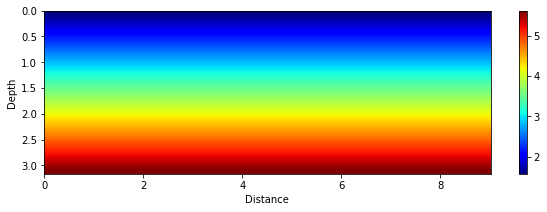

In [4]:

#  Load the velocity model 
vel = np.load(Fvel)
print(f'vel shape {vel.shape} (nx,nz)')

#  load data 
data = np.load(Fdata)
print(f'data shape {data.shape} (nt,ns,nr)')

#  load wavelet 
wavl = np.load(Fwav)
print(f' wavl shape {wavl.shape} (nt,1,1)')





plot_model(vel,par)



#### Convert arrays to tensor 

In [5]:
# Get a mask for the water layer (P.S water veocity = 1.5 km/s)
# msk_water = mask(vel,1.5)
msk_water = np.ones_like(vel)
msk_water[:10,] =  0

# convert to tensor
vel = torch.tensor(vel,dtype=torch.float32)
data = torch.tensor(data)
wavl = torch.tensor(wavl)






### Initialize FWI class 

In [6]:

# initialize the fwi class
inversion = fwi.fwi(nx,nz,dx,nt,dt,num_dim,num_shots,
                    num_sources_per_shot,source_spacing,os,
                    num_receiver_per_shot,receiver_spacing,orec,
                    source_depth,receivers_depth,num_batches)


#### Forward modelling 
    
You don't need to do this step, it is already done to create the observed data 

In [7]:
# Ricker wavelet
# wavl = inversion.Ricker(freq)
# # Foeward modelling 
# data = torch.zeros((nt,num_shots,num_receiver_per_shot),dtype=torch.float32)
# data = inversion.forward_modelling(vel,wavl.repeat(1,num_shots,num_sources_per_shot),device)


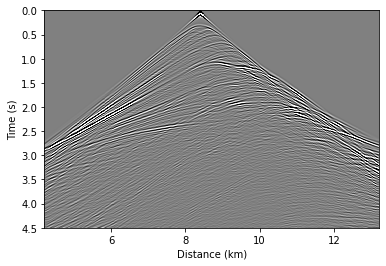

In [8]:
plot_shot(data,14,par)


#### Filter data and wavelet for multi-scaling 

In [21]:
def butter_bandpass(lowcut, highcut, fs,btype ,order=7):
    nyq = 0.5 * fs
    if lowcut != None: low = lowcut / nyq
    if highcut != None: high = highcut / nyq

    if btype == 'band': b, a = signal.butter(order, [low, high], btype=btype, analog=False)
    if btype == 'low':  b, a = signal.butter(order, high, btype=btype, analog=False)
    if btype == 'high': b, a = signal.butter(order,low, btype=btype, analog=False)
    
    return b, a        

def butter_bandpass_filter(data,lowcut=None,highcut=None,fs=None,btype='band',order=7):
    """
    This functions create a butterworth filter and apply the bandpass/high_cut/low_cut filters to the data  

    Arguments:
    ----------
            data   :     1D array that will be filtered 
            lowcut :   The lower band of frequency  [None for law_pass_filter] 
            highcut:  The high band of frequency  [None for high_pass filter]
            btype  :  filtertype ['band','low','high']
            order  :  order of the butterworth filter 
    for more details - check the scipy documentation 
    """
    b, a = butter_bandpass(lowcut, highcut, fs,btype, order=order)
    y = signal.filtfilt(b, a, data)
    return y 



cut= 5 #<the highest freq>
wavl_f = torch.from_numpy(butter_bandpass_filter(
         wavl.view(wavl.shape[0]).numpy(),lowcut=None,highcut=cut,fs=fs,btype='low').copy()).view(wavl.shape[0],1,1)
# Filtering the data  
# Check better method to filter 2D faster 
data_f = torch.zeros_like(data)
for ix in range(data.shape[1]):
    for s in range(data.shape[2]):
        data_f[:,ix,s] =torch.from_numpy(butter_bandpass_filter(
        data[:,ix,s].view(data[:,ix,s].shape[0]).numpy(),lowcut=None,highcut=cut,fs=fs,btype='low').copy()).view(data[:,ix,s].shape[0])


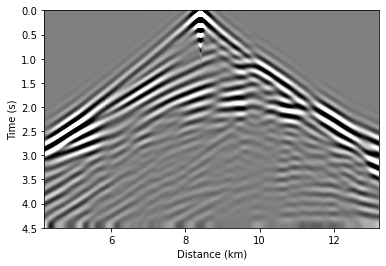

In [22]:
# Plotting giltered data 
plot_shot(data_f,14,par)


### Run inversion 

In [23]:
# v_inv,loss  = inversion.run_inversion(vel,data,wavl,msk_water,
#                                       FWI_itr,[0.5,2],device) 


## For filtered data 
vel = torch.from_numpy(v_inv[-1,]) ## use for subsequent inversion 
v_inv,loss  = inversion.run_inversion(vel,data_f,wavl_f,msk_water,
                                      FWI_itr,[0.5,2],device) 




Iteration:  0 Objective:  5.9768818985959915e-15
Iteration:  1 Objective:  5.975662065272827e-15
Iteration:  2 Objective:  5.984048962000065e-15
Iteration:  3 Objective:  5.999109313681365e-15
Iteration:  4 Objective:  6.0178668053587525e-15
Iteration:  5 Objective:  6.039201712415516e-15
Iteration:  6 Objective:  6.061903042434879e-15
Iteration:  7 Objective:  6.085819229458841e-15
Iteration:  8 Objective:  6.110476940888565e-15
Iteration:  9 Objective:  6.1350878008083936e-15
Iteration:  10 Objective:  6.159567000044484e-15
Iteration:  11 Objective:  6.184123120460096e-15
Iteration:  12 Objective:  6.208716669144066e-15
Iteration:  13 Objective:  6.23322614980802e-15
Iteration:  14 Objective:  6.257638168743481e-15
Iteration:  15 Objective:  6.2817101039506194e-15
Iteration:  16 Objective:  6.305340734992238e-15
Iteration:  17 Objective:  6.328645681865638e-15
Iteration:  18 Objective:  6.3515344179245804e-15
Iteration:  19 Objective:  6.3746489941430846e-15
Iteration:  20 Objective:

#### Plotting the objective function and the inversion results 
Note the inversion save the model every 5 iteration. Thus `v_inv` will have the sape of `(#update//5,nz,nx)`

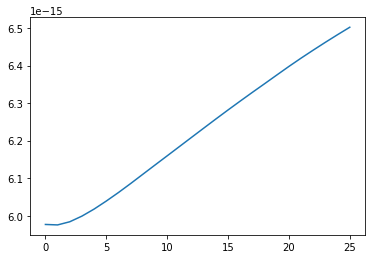

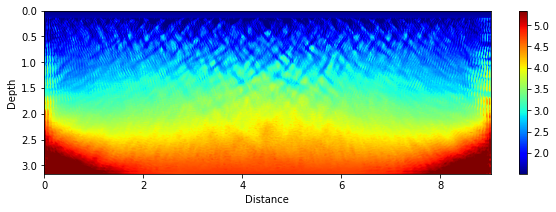

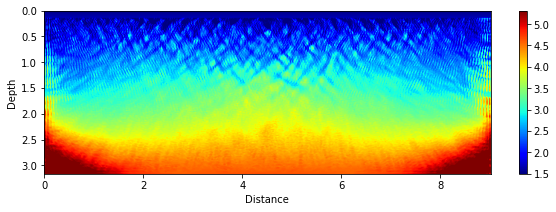

IndexError: index 3 is out of bounds for axis 0 with size 3

In [24]:

## plotting the objective 
plt.plot(loss)
plot_model(v_inv[0,:,:],par)
plot_model(v_inv[2,:,:],par)
plot_model(v_inv[3,:,:],par)
## plotting the final inversion results 
plot_model(v_inv[-1,:,:],par)


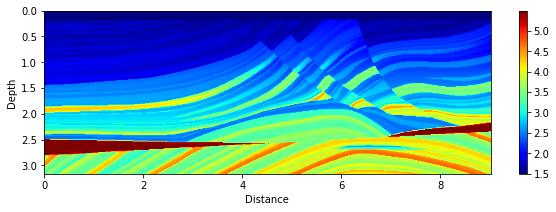

In [12]:
vel = np.load('./input_files/vel_true.npy')
plot_model(vel,par)